In [1]:
from gensim import corpora, models, similarities
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import logging, gensim
import pickle
from sklearn import metrics

import time
import urllib2
from bs4 import BeautifulSoup
import itertools
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.grid_search import GridSearchCV
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sqlalchemy_utils import database_exists, create_database
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8  # plotsize
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 14

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


### V5: consider using the classification probability as the matching degree (different from V4)

In [2]:
def LSI_tfidf_model(dictionary, mm, tfidfmodel, num_topics=200):
    corpus_tfidf = tfidfmodel[mm]  # transform to tfidf space and then perform LSI
    
    lsimodel = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics) # initialize an LSI transformation
    lsimodel.show_topics(num_topics=10, num_words=20)
    lsimodel.print_topics(num_topics=5, num_words=10)
    
    corpus_lsi = lsimodel[corpus_tfidf] # doc-topic matrix in LSI space
    
    index = similarities.MatrixSimilarity(corpus_lsi) # transform corpus to LSI
    
    return lsimodel, corpus_lsi, index  # all in the tfidf space (instead of bag-of-words)

## Validation through text classification using document-topic matrix

### load the jobs table

In [3]:
path = '/home/hxzheng/Insight_DS_Fellowship/Project/JobRecomm/Resume_text/'

In [4]:
j=0
num_topics=50
jobs=pd.read_pickle(path + "jobs_table.dat") 
dictionary = gensim.corpora.Dictionary.load(path + 'dict'+str(j)+'.dict')
mm = gensim.corpora.MmCorpus(path + 'corpus'+str(j)+'.mm')
tfidfmodel = models.TfidfModel.load(path + 'tfidfmodel'+str(j)+'.tfidf')

lsimodel,corpus_lsi,index = LSI_tfidf_model(dictionary, mm, tfidfmodel, num_topics=num_topics)

In [5]:
### save index for later similarity queries

index.save(path + 'final_lsimodel.index')
lsimodel.save(path + 'final_lsimodel.lsi')

In [6]:
xtrain, ytrain = [], []
for i,doc_lsi in enumerate(corpus_lsi):
    if doc_lsi!=[]:                              # filter out empty documents
        xtrain.append([w[1] for w in doc_lsi])
        ytrain.append(jobs.ix[i]['jobid'])

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [10]:
np.unique(ytrain).shape

(4,)

In [14]:
ytrain.shape[0]

2816

In [15]:
KFoldNumber=10
kfold = StratifiedKFold(ytrain, KFoldNumber,shuffle=True, random_state = 100)
ycv=np.zeros(ytrain.shape)
ycv_proba=np.zeros((ytrain.shape[0],np.unique(ytrain).shape[0]))

In [16]:
for train,cv in kfold:
    x = xtrain[train,:]
    y = ytrain[train]
    xcv = xtrain[cv,:]
    RF = RandomForestClassifier(n_estimators = 500, n_jobs = -1,random_state =100, \
                                    max_features = "auto", min_samples_leaf = 1)
    RF = RF.fit(x,y)
    ycv[cv] = RF.predict(xcv)
    ycv_proba[cv,:]=RF.predict_proba(xcv)

In [17]:
print(metrics.accuracy_score(ytrain, ycv))

0.869673295455


In [20]:
print ycv_proba[:20,:]

[[ 0.9    0.034  0.024  0.042]
 [ 0.834  0.04   0.07   0.056]
 [ 0.948  0.028  0.016  0.008]
 [ 0.892  0.062  0.024  0.022]
 [ 0.818  0.05   0.102  0.03 ]
 [ 0.928  0.012  0.046  0.014]
 [ 0.484  0.092  0.28   0.144]
 [ 0.754  0.048  0.102  0.096]
 [ 0.628  0.19   0.138  0.044]
 [ 0.906  0.05   0.028  0.016]
 [ 0.866  0.026  0.09   0.018]
 [ 0.064  0.782  0.114  0.04 ]
 [ 0.774  0.052  0.092  0.082]
 [ 0.682  0.024  0.146  0.148]
 [ 0.96   0.01   0.018  0.012]
 [ 0.364  0.048  0.416  0.172]
 [ 0.926  0.02   0.022  0.032]
 [ 0.94   0.022  0.026  0.012]
 [ 0.916  0.024  0.024  0.036]
 [ 0.274  0.116  0.24   0.37 ]]


In [21]:
print RF.classes_
print RF.feature_importances_

[0 1 2 3]
[ 0.02461554  0.19099239  0.18826219  0.06978283  0.03872317  0.02216745
  0.03754882  0.01682945  0.0346032   0.0152402   0.01163731  0.01320426
  0.01339887  0.01224071  0.01175545  0.01378599  0.01420356  0.01127215
  0.00973042  0.01021504  0.00841038  0.00919486  0.00868992  0.00876935
  0.00723061  0.01819798  0.01130084  0.00717926  0.00832772  0.00743308
  0.00794866  0.00719824  0.00821748  0.00724926  0.0076023   0.00781575
  0.0068856   0.0080054   0.00682558  0.00700302  0.00683376  0.00595592
  0.00716679  0.00642621  0.00780995  0.00720056  0.00813781  0.0068689
  0.00770501  0.00620077]


In [22]:
print ytrain[0:50]
print ycv[0:50]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.  0.
  0.  3.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [23]:
ycv_counts = []
jobtitles = jobs['jobtitle'].unique()
for jid,jtitle in enumerate(jobtitles):
    print jid,jtitle
    ind = np.where(ytrain == jid)[0]
    ycv_ind = pd.Series(ycv[ind])
    count = ycv_ind.value_counts()
    count = np.unique(ycv[ind],return_counts=True)
    ycv_counts.append(count[1])
print ycv_counts   

0 Data Scientist
1 Software Engineer
2 Consultant
3 Strategy Manager
[array([622,  24,  29,  16]), array([ 17, 646,  25,   2]), array([ 29,  70, 524,  84]), array([  6,   3,  62, 657])]


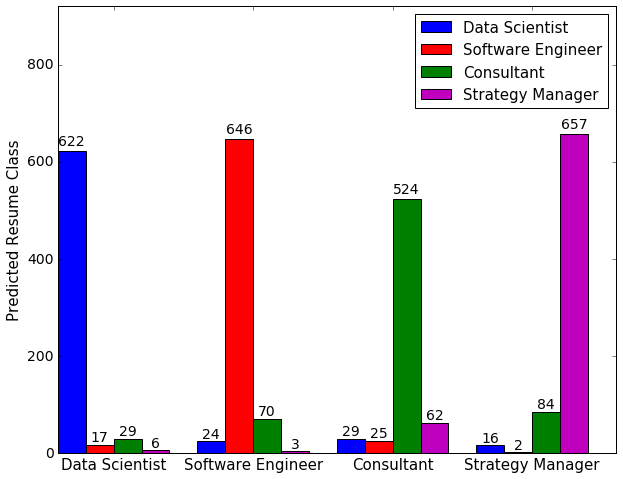

In [24]:
## make plot
ind = np.arange(len(jobtitles))  # the x locations for the groups
width = 0.2       # the width of the bars
fig, ax = plt.subplots()
colors = ['b','r','g','m']

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')
        
for i in range(len(jobtitles)):
    rects=ax.bar(ind+i*width, ycv_counts[i], width, color=colors[i])
    autolabel(rects)
    
fs=15
ax.set_ylabel('Predicted Resume Class',fontsize=fs)
ax.set_xticks(ind + 2*width)
ax.set_xticklabels(jobtitles,fontsize=fs)
ax.set_ylim(0,920)

ax.legend(jobtitles,fontsize=fs)
fig.savefig(path + 'finalclassification.png', bbox_inches='tight')